In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime

from pycaret.regression import *
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

pd.options.display.max_colwidth = 1000
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format) #evitar notacion cientifica

In [2]:
####################################################
############# Setear segun cada maquina ############
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [3]:
seed = 456456465

In [4]:
def error_rate(y, y_pred):
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    
    return round(100*dif_abs/suma_real,2)

In [5]:
df_file = "emp3_sellout_base_period_product.csv"
df_sellout = pd.read_csv(df_file)
df_sellout.head()

,periodo,periodo_fecha,product_id,tn,cust_request_qty,cust_request_tn,plan_precios_cuidados,cat1,cat2,cat3,sku_size,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe
0,201701,2017-01-01,20001,934.77,479,937.73,0,HC,ROPA LAVADO,Liquido,3000.00,25.65,30.40,20.90,1.60,15.91,False
1,201701,2017-01-01,20002,550.16,391,555.19,0,HC,ROPA LAVADO,Liquido,3000.00,25.65,30.40,20.90,1.60,15.91,False
2,201701,2017-01-01,20003,1063.46,438,1067.82,0,FOODS,ADEREZOS,Mayonesa,475.00,25.65,30.40,20.90,1.60,15.91,False
3,201701,2017-01-01,20004,555.92,339,569.37,0,FOODS,ADEREZOS,Mayonesa,240.00,25.65,30.40,20.90,1.60,15.91,False
4,201701,2017-01-01,20005,494.27,249,494.60,0,FOODS,ADEREZOS,Mayonesa,120.00,25.65,30.40,20.90,1.60,15.91,False


In [6]:
df_sellout['periodo_fecha'] = pd.to_datetime(df_sellout['periodo_fecha'])
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31243 entries, 0 to 31242
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   periodo                    31243 non-null  int64         
 1   periodo_fecha              31243 non-null  datetime64[ns]
 2   product_id                 31243 non-null  int64         
 3   tn                         31243 non-null  float64       
 4   cust_request_qty           31243 non-null  int64         
 5   cust_request_tn            31243 non-null  float64       
 6   plan_precios_cuidados      31243 non-null  int64         
 7   cat1                       31243 non-null  object        
 8   cat2                       31243 non-null  object        
 9   cat3                       31243 non-null  object        
 10  sku_size                   31243 non-null  float64       
 11  temp_media                 31243 non-null  float64       
 12  temp

In [7]:
df_sellout['mes'] = [i.month for i in df_sellout['periodo_fecha']]
df_sellout['anio'] = [i.year for i in df_sellout['periodo_fecha']]
df_sellout['Series'] = np.arange(1,len(df_sellout)+1)

# drop unnecessary columns and re-arrange
df_sellout.drop(['periodo_fecha'], axis=1, inplace=True)

df_sellout.head()

,periodo,product_id,tn,cust_request_qty,cust_request_tn,plan_precios_cuidados,cat1,cat2,cat3,sku_size,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,mes,anio,Series
0,201701,20001,934.77,479,937.73,0,HC,ROPA LAVADO,Liquido,3000.00,25.65,30.40,20.90,1.60,15.91,False,1,2017,1
1,201701,20002,550.16,391,555.19,0,HC,ROPA LAVADO,Liquido,3000.00,25.65,30.40,20.90,1.60,15.91,False,1,2017,2
2,201701,20003,1063.46,438,1067.82,0,FOODS,ADEREZOS,Mayonesa,475.00,25.65,30.40,20.90,1.60,15.91,False,1,2017,3
3,201701,20004,555.92,339,569.37,0,FOODS,ADEREZOS,Mayonesa,240.00,25.65,30.40,20.90,1.60,15.91,False,1,2017,4
4,201701,20005,494.27,249,494.60,0,FOODS,ADEREZOS,Mayonesa,120.00,25.65,30.40,20.90,1.60,15.91,False,1,2017,5


In [8]:
df_train = df_sellout[df_sellout.periodo <= 201902]
print(len(df_train))
df_test = df_sellout[df_sellout.periodo == 201904]
print(len(df_test))

21993
919


In [9]:
df_train_model = df_train.drop(columns=["periodo","cust_request_tn","cust_request_qty"])
df_test_model = df_test.drop(columns=["periodo","cust_request_tn","cust_request_qty"])

In [10]:
clf = setup(
            data = df_train_model,
            test_data=df_test_model,
            fold_strategy = 'timeseries',
            data_split_stratify=False,
            data_split_shuffle=False,
            session_id=seed,
            target = 'tn')


#Metricas
previous_metric_names = get_metrics().Name

for metric_name in previous_metric_names:
    remove_metric(metric_name)

add_metric('error_rate', 'Error Rate', error_rate, greater_is_better = False)

model = compare_models  (
                        sort="error_rate"
                        )

,Description,Value
0,Session id,456456465
1,Target,tn
2,Target type,Regression
3,Original data shape,"(22912, 16)"
4,Transformed data shape,"(22912, 34)"
5,Transformed train set shape,"(21993, 34)"
6,Transformed test set shape,"(919, 34)"
7,Numeric features,11
8,Categorical features,3
9,Preprocess,True


,Model,Error Rate,TT (Sec)
rf,Random Forest Regressor,29.1210,2.5520
et,Extra Trees Regressor,30.2060,1.4450
lightgbm,Light Gradient Boosting Machine,30.6680,0.6250
xgboost,Extreme Gradient Boosting,33.2950,0.1620
gbr,Gradient Boosting Regressor,36.4870,0.7250
dt,Decision Tree Regressor,37.9730,0.0920
ada,AdaBoost Regressor,62.0880,0.4120
huber,Huber Regressor,83.7080,0.1770
knn,K Neighbors Regressor,106.7260,0.2610
en,Elastic Net,111.2480,0.0770


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

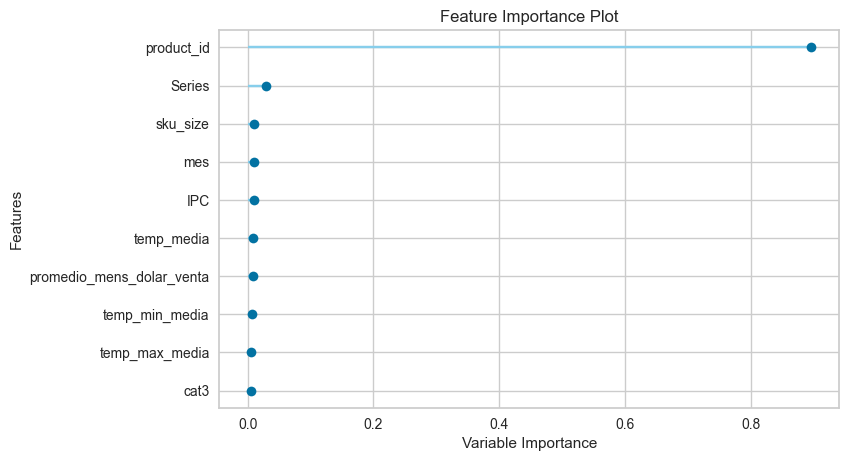

In [11]:
plot_model(model, plot = 'feature')

In [12]:
#interpret_model(model)

In [13]:
prediction_holdout = predict_model(model)

prediction_holdout

,Model,Error Rate
0,Random Forest Regressor,27.7400


,product_id,plan_precios_cuidados,cat1,cat2,cat3,sku_size,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,mes,anio,Series,tn,prediction_label
22888,20001,0,HC,ROPA LAVADO,Liquido,3000.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22889,1647.64,1372.79
22889,20002,0,HC,ROPA LAVADO,Liquido,3000.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22890,1287.62,1023.83
22890,20003,0,FOODS,ADEREZOS,Mayonesa,475.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22891,565.34,819.29
22891,20004,0,FOODS,ADEREZOS,Mayonesa,240.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22892,466.71,573.81
22892,20005,0,FOODS,ADEREZOS,Mayonesa,120.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22893,625.00,533.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23802,21266,0,PC,PIEL1,CUIDADO ESPECIAL,32.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,23803,0.36,0.16
23803,21267,0,PC,PIEL1,Cara,250.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,23804,0.12,0.24
23804,21269,0,PC,PIEL1,Cuerpo,200.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,23805,0.11,0.23
23805,21271,0,FOODS,TE,Frutas,20.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,23806,0.00,0.06


In [14]:
prediction_holdout[prediction_holdout.product_id==20001]

,product_id,plan_precios_cuidados,cat1,cat2,cat3,sku_size,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,mes,anio,Series,tn,prediction_label
22888,20001,0,HC,ROPA LAVADO,Liquido,3000.00,19.30,24.30,15.00,3.40,43.26,False,4,2019,22889,1647.64,1372.79


In [15]:
final_best = finalize_model(model)